In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Đọc dữ liệu
data = pd.read_csv('/content/drive/MyDrive/Stock/Apple.csv')
data = data.dropna()
df = data.reset_index()['Close']

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [14]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [15]:
# Hàm tạo dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
# Xây dựng mô hình XGBoost
# model = XGBRegressor(n_estimators=100)
model = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:02:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [17]:
# Dự đoán
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [18]:
# Chuyển đổi dự đoán về dạng ban đầu
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

In [19]:
# Dự đoán 30 ngày tiếp theo
last_data = test_data[-time_step:]
next30days_predict = []
for i in range(30):
    X = last_data[-time_step:]
    y_pred = model.predict(X.reshape(1, -1))
    next30days_predict.append(y_pred[0])
    last_data = np.append(last_data, y_pred[0])[1:]

next30days_predict = scaler.inverse_transform(np.array(next30days_predict).reshape(-1, 1))

In [20]:
#Calculate evalution
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - test_predict)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((test_predict - y_pred) / test_predict))
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred - test_predict))
print('Testing MAE:', test_mae)

Testing RMSE: 172.50258
Testing MAPE: 0.99634516
Testing MAE: 172.48624


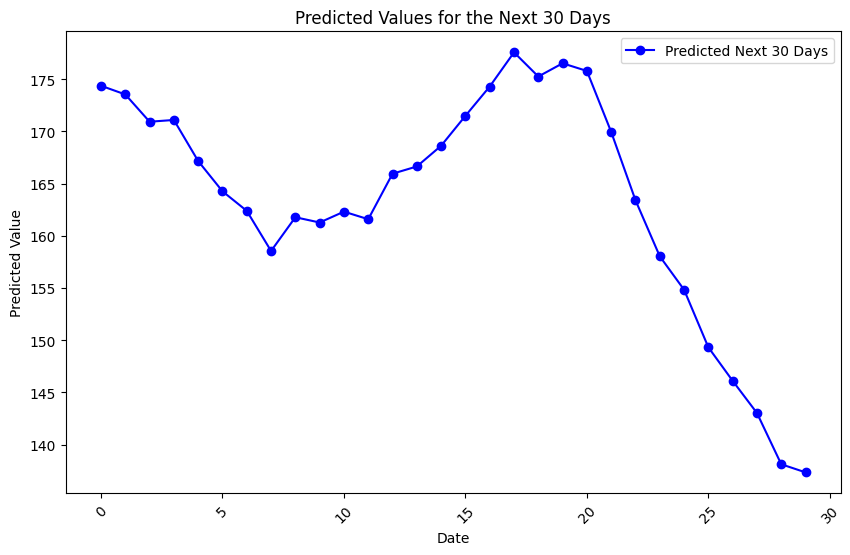

In [21]:

# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(next30days_predict, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()

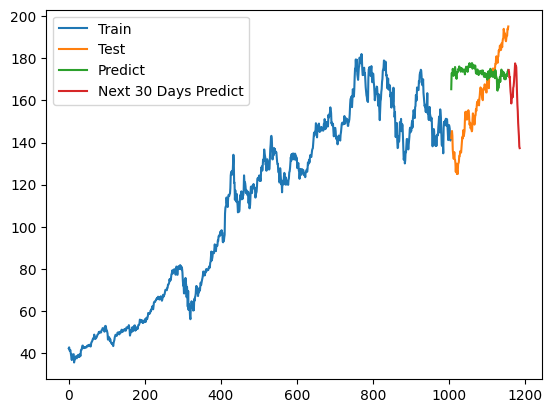

In [22]:
# Biểu đồ
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(df.index[train_size:train_size+len(test_predict)], scaler.inverse_transform(test_data)[:len(test_predict)], label='Predict')
plt.plot(df.index[train_size:train_size+len(test_predict)], test_predict, label='Test')
plt.plot(df.index[train_size+len(test_predict):train_size+len(test_predict)+30], next30days_predict, label ='Next 30 Days Predict')
plt.legend(['Train', 'Test', 'Predict', 'Next 30 Days Predict'])
#plt.legend()
plt.show()

# plt.plot(y_train_index, y_train)
# plt.plot(y_test.index, y_test)
# plt.plot(y_test.index, y_pred)
# plt.plot(next_30_dates,x_next_30_days)
# plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
# plt.show()